# Machine Learning Pipeline for Soccer Match Prediction

This notebook implements a comprehensive machine learning pipeline for predicting soccer match outcomes using the European Soccer Database. The pipeline includes data extraction, feature engineering, preprocessing, and training of both Logistic Regression and MLP models.

### Key Features:
- Data integration from multiple database tables
- Feature engineering with team and player attributes
- Temporal weighting for recent performance emphasis
- Advanced preprocessing with PCA dimensionality reduction
- Model comparison between Logistic Regression and Neural Networks
- Performance evaluation with cross-validation and confusion matrices

### Models Trained:
1. **Logistic Regression** - Linear classification model
2. **Multi-Layer Perceptron (MLP)** - Neural network classifier

### Dataset:
[European Soccer Database containing match results, team attributes, and player statistics](https://www.kaggle.com/datasets/hugomathien/soccer?resource=download)

### 1. Library Imports and Dependencies
Setting up the required libraries for data processing, machine learning, model evaluation, and visualization.

**Key libraries:**
- **pandas, numpy**: Data manipulation and numerical operations
- **sklearn**: Machine learning algorithms and preprocessing
- **matplotlib**: Data visualization
- **sqlite3**: Database connectivity
- **pickle, json**: Model serialization and data persistence

In [2]:
import pandas as pd
import _sqlite3 as db
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pickle, json
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import numpy as np

### 2. Database Connection and Data Extraction
Connecting to the European Soccer Database and extracting table information to understand the available data structure.

**Database tables:**
- **Match**: Game results and statistics
- **Team**: Team information
- **Player**: Player profiles
- **Team_Attributes**: Team tactical attributes
- **Player_Attributes**: Player skill ratings

In [1]:
# function for tables extraction
def extract_tables(cursor):
    for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
        print(row)

# Extraction tables from European Soccer Database (https://www.kaggle.com/datasets/hugomathien/soccer?resource=download)
con_euro = db.connect('Data/EuroSoccer.sqlite')
cursor = con_euro.cursor()

print("Tables from European Soccer Database:\n")
extract_tables(cursor)
print('\n')

with open('../notebooks/embeddings_data.pkl', 'rb') as f:
    embeddings_data = pickle.load(f)

print(f"Downloaded embeddings for {len(embeddings_data['player_id_to_idx'])} players")

NameError: name 'db' is not defined

### 3. Data Loading and Table Integration
Loading all relevant tables from the database and examining their structure. This step also loads pre-computed player embeddings for enhanced feature representation.

**Key datasets loaded:**
- Match results and statistics
- Team and player information
- Tactical attributes for teams
- Player skill ratings and embeddings

In [4]:
# Extraction data from Euro Soccer
match_table = pd.read_sql_query("SELECT * FROM Match;", con_euro)
team_table = pd.read_sql_query("SELECT * FROM Team;", con_euro)
team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes;", con_euro)
country_table = pd.read_sql_query("SELECT * FROM Country;", con_euro)
players = pd.read_sql_query("SELECT * FROM Player;", con_euro)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes;", con_euro)
leagues_table = pd.read_sql_query("SELECT * FROM League;", con_euro)

# Look up of all data
print(f"match_table: {match_table.columns.tolist()}\n")
print(f"team_table: {team_table.columns.tolist()}\n")
print(f"team_attributes: {team_attributes.columns.tolist()}\n")
print(f"country_table: {country_table.columns.tolist()}\n")
print(f"players: {players.columns.tolist()}\n")
print(f"player_attributes: {player_attributes.columns.tolist()}\n")
print(f"leagues: {leagues_table.columns.tolist()}\n")

match_table: ['id', 'country_id', 'league_id', 'season', 'stage', 'date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4', 'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9', 'home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8', 'away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1', 'home_player_2', 

### 4. Match Result Label Generation
Creating target labels for supervised learning by converting match scores into categorical outcomes.

**Label mapping:**
- `1`: Home team win
- `0`: Draw
- `-1`: Away team win

These labels will be used as ground truth for model training and evaluation.

In [5]:
def create_match_result(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return 1  # Home win
    elif row['home_team_goal'] < row['away_team_goal']:
        return -1  # Away win
    else:
        return 0  # Draw

match_table['result'] = match_table.apply(create_match_result, axis=1)
match_table['result_label'] = match_table['result'].map({1: 'home_win', 0: 'draw', -1: 'away_win'})

### 5. Data Integration and Enhancement
Merging match data with team information, leagues, and country data to create a comprehensive dataset with all relevant context for each match.

**Integration process:**
1. Merge matches with league information
2. Add country context
3. Include home and away team details
4. Create enhanced feature set

In [6]:
matches_enhanced = match_table.merge(
    leagues_table, left_on='league_id', right_on='id', how='left', suffixes=('', '_league')
).merge(
    country_table, left_on='country_id', right_on='id', how='left', suffixes=('', '_country')
)
matches_enhanced = matches_enhanced.merge(
    team_table, left_on='home_team_api_id', right_on='team_api_id',
    how='left', suffixes=('', '_home_team')
)
matches_enhanced.rename(columns={
    'team_long_name': 'home_team_name',
    'team_short_name': 'home_team_short'
}, inplace=True)
matches_enhanced = matches_enhanced.merge(
    team_table, left_on='away_team_api_id', right_on='team_api_id',
    how='left', suffixes=('', '_away_team')
)
matches_enhanced.rename(columns={
    'team_long_name': 'away_team_name',
    'team_short_name': 'away_team_short'
}, inplace=True)

print(f"The main dataset has been created: {matches_enhanced.shape}")

The main dataset has been created: (25979, 132)


### 6. Player Data Extraction and Aggregation
Implementing functions to extract player information for specific matches and aggregate player statistics at the team level.

**Key functions:**
- `get_match_players()`: Extract player lineup for matches
- `get_players_attributes_for_match()`: Get player attributes closest to match date
- `aggregate_team_player_stats()`: Aggregate individual player stats into team-level features

**Aggregation methods:**
- Mean, max, min, standard deviation of player attributes
- Categorical features (preferred foot, work rates)

In [7]:
def get_match_players(match_row, team_type='home'):
    player_columns = [f'{team_type}_player_{i}' for i in range(1, 12)]
    players = []
    for col in player_columns:
        if col in match_row and pd.notna(match_row[col]):
            players.append(int(match_row[col]))
    return players

def get_players_attributes_for_match(player_ids, match_date, player_attributes):
    if not player_ids:
        return pd.DataFrame()
    match_date = pd.to_datetime(match_date)
    relevant_attributes = player_attributes[
        player_attributes['player_api_id'].isin(player_ids)
    ].copy()

    if relevant_attributes.empty:
        return pd.DataFrame()
    relevant_attributes['date'] = pd.to_datetime(relevant_attributes['date'])
    player_attrs_list = []
    for player_id in player_ids:
        player_data = relevant_attributes[
            (relevant_attributes['player_api_id'] == player_id) &
            (relevant_attributes['date'] <= match_date)
        ]

        if not player_data.empty:
            latest_attr = player_data.loc[player_data['date'].idxmax()]
            player_attrs_list.append(latest_attr)

    if player_attrs_list:
        return pd.DataFrame(player_attrs_list)
    else:
        return pd.DataFrame()

def aggregate_team_player_stats(team_players_attrs):
    if team_players_attrs.empty:
        return {}
    key_attributes = [
        'overall_rating', 'potential', 'crossing', 'finishing', 'heading_accuracy',
        'short_passing', 'long_passing', 'ball_control', 'acceleration', 'sprint_speed',
        'agility', 'shot_power', 'stamina', 'strength', 'aggression', 'interceptions',
        'positioning', 'vision', 'marking', 'standing_tackle', 'sliding_tackle'
    ]
    aggregated_stats = {}
    for attr in key_attributes:
        if attr in team_players_attrs.columns and not team_players_attrs[attr].isna().all():
            aggregated_stats[f'{attr}_mean'] = team_players_attrs[attr].mean()
            aggregated_stats[f'{attr}_max'] = team_players_attrs[attr].max()
            aggregated_stats[f'{attr}_min'] = team_players_attrs[attr].min()
            aggregated_stats[f'{attr}_std'] = team_players_attrs[attr].std()
    if 'preferred_foot' in team_players_attrs.columns:
        foot_counts = team_players_attrs['preferred_foot'].value_counts()
        aggregated_stats['right_foot_players'] = foot_counts.get('right', 0)
        aggregated_stats['left_foot_players'] = foot_counts.get('left', 0)
    if 'attacking_work_rate' in team_players_attrs.columns:
        work_rate_counts = team_players_attrs['attacking_work_rate'].value_counts()
        aggregated_stats['high_attack_work_rate'] = work_rate_counts.get('high', 0)
        aggregated_stats['medium_attack_work_rate'] = work_rate_counts.get('medium', 0)
        aggregated_stats['low_attack_work_rate'] = work_rate_counts.get('low', 0)
    if 'defensive_work_rate' in team_players_attrs.columns:
        def_work_rate_counts = team_players_attrs['defensive_work_rate'].value_counts()
        aggregated_stats['high_defence_work_rate'] = def_work_rate_counts.get('high', 0)
        aggregated_stats['medium_defence_work_rate'] = def_work_rate_counts.get('medium', 0)
    return aggregated_stats

### 7. Team Tactical Attributes Integration
Implementing functions to retrieve team tactical attributes that are closest to each match date, ensuring temporal consistency in the dataset.

**Key features:**
- Build-up play characteristics
- Chance creation patterns
- Defensive strategies
- Team positioning and width

In [8]:
def get_team_attributes_for_match(match_date, team_api_id, team_attributes):
    team_attrs = team_attributes[team_attributes['team_api_id'] == team_api_id].copy()
    if team_attrs.empty:
        return pd.Series()

    team_attrs['date'] = pd.to_datetime(team_attrs['date']) # date representation
    match_date = pd.to_datetime(match_date)
    valid_attrs = team_attrs[team_attrs['date'] <= match_date]
    if valid_attrs.empty:
        return team_attrs.iloc[0]

    return valid_attrs.loc[valid_attrs['date'].idxmax()]

def get_team_embeddings(match_row, team_type, embeddings_data):
    player_cols = [f"{team_type}_player_{i}" for i in range(1, 12)]
    player_ids = [int(match_row[col]) for col in player_cols if pd.notna(match_row[col])]
    idx_map = embeddings_data['player_id_to_idx']
    valid_idxs = [idx_map[pid] for pid in player_ids if pid in idx_map]
    profiles_df = embeddings_data['profiles_df']
    if not valid_idxs:
        return np.zeros(len(embeddings_data['numeric_features']))
    team_embs = profiles_df.iloc[valid_idxs][embeddings_data['numeric_features']].values
    return team_embs.mean(axis=0)

### 8. Comprehensive ML Dataset Construction
Creating the final machine learning dataset by combining all features:

**Feature types:**
1. **Team embeddings**: Pre-computed player embeddings aggregated at team level
2. **Tactical attributes**: Team playing style characteristics
3. **Temporal features**: Season and stage information

**Processing steps:**
1. Extract team embeddings for home and away teams
2. Merge with tactical attributes
3. Create temporal features
4. Generate target labels

In [9]:
def create_comprehensive_ml_dataset(matches_df, team_attributes, player_attributes):
    ml = matches_df.copy()
    ml['season_encoded'] = ml['season'].str.replace('/', '').astype(int)
    ml['stage'] = ml['stage'].fillna(0)
    feature_rows = []
    total = len(ml)
    for idx, match in ml.iterrows():
        if idx % 3000 == 0:
            print(f"Processed {idx} from {total}")
        home_attr = get_team_attributes_for_match(match['date'], match['home_team_api_id'], team_attributes)
        away_attr = get_team_attributes_for_match(match['date'], match['away_team_api_id'], team_attributes)
        row = {}
        home_emb = get_team_embeddings(match, 'home', embeddings_data)
        away_emb = get_team_embeddings(match, 'away', embeddings_data)
        for i, feat in enumerate(embeddings_data['numeric_features']):
            row[f'home_emb_{feat}'] = home_emb[i]
            row[f'away_emb_{feat}'] = away_emb[i]
        for col in [
            'buildUpPlaySpeed','buildUpPlayPassing','chanceCreationPassing',
            'chanceCreationCrossing','chanceCreationShooting','defencePressure',
            'defenceAggression','defenceTeamWidth'
        ]:
            row[f'home_{col}'] = home_attr.get(col, np.nan)
            row[f'away_{col}'] = away_attr.get(col, np.nan)

        row['result_label'] = match['result_label']
        feature_rows.append(row)
    features_df = pd.DataFrame(feature_rows, index=ml.index)
    comprehensive = pd.concat([ml, features_df], axis=1)
    print(f"Comprehensive dataset shape: {comprehensive.shape}")
    return comprehensive

comprehensive_dataset = create_comprehensive_ml_dataset(matches_enhanced, team_attributes, player_attributes)

print(f"A comprehensive dataset has been created: {comprehensive_dataset.shape}")
print(comprehensive_dataset.head())

Processed 0 from 25979
Processed 3000 from 25979
Processed 6000 from 25979
Processed 9000 from 25979
Processed 12000 from 25979
Processed 15000 from 25979
Processed 18000 from 25979
Processed 21000 from 25979
Processed 24000 from 25979
Comprehensive dataset shape: (25979, 220)
A comprehensive dataset has been created: (25979, 220)
   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492473              9987              9993               1  ...   
1        492474             10000              9994               0  ...   
2        492

### 9. Data Quality Assessment and Missing Value Analysis
Analyzing the dataset for missing values and data quality issues to inform preprocessing decisions.

**Key metrics:**
- Missing value counts by column
- Percentage of complete records
- Data distribution analysis

**Quality checks:**
- Identify columns with excessive missing values
- Analyze patterns in missing data
- Determine preprocessing strategies

In [10]:
comprehensive_dataset['result'] = comprehensive_dataset.apply(create_match_result, axis=1)
comprehensive_dataset['result_label'] = comprehensive_dataset['result'].map({1: 'home_win', 0: 'draw', -1: 'away_win'})

comprehensive_dataset = comprehensive_dataset.loc[:,~comprehensive_dataset.columns.duplicated()]
comprehensive_dataset = comprehensive_dataset[comprehensive_dataset['result_label'] != 'draw'].reset_index(drop=True)

rows_with_nan = comprehensive_dataset.isnull().any(axis=1).sum()
total_rows = len(comprehensive_dataset)
rows_without_nan = total_rows - rows_with_nan

print(f"Number of notes with NaN: {rows_with_nan}")
print(f"Overall number of notes in dataset: {total_rows}")

def analyze_missing_data(df):
    nan_by_column = df.isnull().sum().sort_values(ascending=False)
    print(f"\nTop 50 lines by number of NaN:")
    print(nan_by_column.head(50))
    rows_with_nan = df.isnull().any(axis=1).sum()
    print(f"\nNumber of notes with at least one NaN: {rows_with_nan} из {len(df)}")
    complete_rows = len(df) - rows_with_nan
    print(f"Full notes: {complete_rows}")

analyze_missing_data(comprehensive_dataset)

Number of notes with NaN: 18079
Overall number of notes in dataset: 19383

Top 50 lines by number of NaN:
PSA                11034
PSD                11034
PSH                11034
BSD                 8841
BSA                 8841
BSH                 8841
GBD                 8840
GBH                 8840
GBA                 8840
goal                8762
foulcommit          8762
corner              8762
possession          8762
cross               8762
card                8762
shotoff             8762
shoton              8762
SJD                 6620
SJH                 6620
SJA                 6620
IWH                 2555
IWD                 2555
IWA                 2555
LBD                 2539
LBA                 2539
LBH                 2539
WHD                 2525
WHA                 2525
WHH                 2525
VCH                 2520
VCD                 2520
VCA                 2520
BWH                 2516
BWA                 2516
BWD                 2516
B365H              

### 10. Missing Value Treatment and Column Filtering
Implementing a systematic approach to handle missing values by removing columns with excessive missing data.

**Strategy:**
1. Rank columns by missing value count
2. Remove top N columns with highest missing values
3. Evaluate impact on dataset completeness
4. Assess trade-off between feature quantity and data quality

**Results:**
- Improved dataset completeness
- Reduced dimensionality
- Better model training stability

In [11]:
def drop_top_n_nan_columns(df, n):
    nan_counts = df.isnull().sum().sort_values(ascending=False)
    top_nan_cols = nan_counts.head(n).index.tolist()
    df_dropped = df.drop(columns=top_nan_cols) # drop tables
    return df_dropped, top_nan_cols, nan_counts.head(n)

dropped_df, dropped_cols, nan_stats = drop_top_n_nan_columns(comprehensive_dataset, n=35)

print("Cleaning results") # Results Analysing
print(f"Default size: {comprehensive_dataset.shape}")
print(f"Size after cleaning: {dropped_df.shape}")
print(f"Number of deleted tables: {len(dropped_cols)}")

total_nan_after = dropped_df.isnull().sum().sum() # NaN calculation
rows_with_nan_after = dropped_df.isnull().any(axis=1).sum()
complete_rows_after = len(dropped_df) - rows_with_nan_after

print(f"\nCurrent number of NaN: {total_nan_after}")
print(f"Number of notes with at least one NaN: {rows_with_nan_after} from {len(dropped_df)}")
print(f"Full notes: {complete_rows_after} ({complete_rows_after/len(dropped_df)*100:.1f}%)")
print(f"\nTop - 10 deleted columns: {len(dropped_cols)}:")
print(nan_stats.head(10))

analyze_missing_data(dropped_df)

print(f"Current number of columns: {len(dropped_df.columns.tolist())}")

Cleaning results
Default size: (19383, 219)
Size after cleaning: (19383, 184)
Number of deleted tables: 35

Current number of NaN: 91398
Number of notes with at least one NaN: 4730 from 19383
Full notes: 14653 (75.6%)

Top - 10 deleted columns: 35:
PSA     11034
PSD     11034
PSH     11034
BSD      8841
BSA      8841
BSH      8841
GBD      8840
GBH      8840
GBA      8840
goal     8762
dtype: int64

Top 50 lines by number of NaN:
B365H              2507
B365D              2507
B365A              2507
away_player_Y11    1363
away_player_X11    1363
away_player_Y10    1359
away_player_X9     1359
away_player_X10    1359
away_player_Y9     1359
away_player_X1     1358
away_player_X2     1358
home_player_Y6     1358
home_player_Y4     1358
home_player_X11    1358
home_player_Y3     1358
away_player_X7     1358
away_player_X3     1358
away_player_X6     1358
home_player_X8     1358
home_player_X9     1358
home_player_X10    1358
home_player_Y5     1358
home_player_X6     1358
home_player_X7

### 11. Feature Availability Verification
Verifying that all required features for model training are available in the cleaned dataset.

**Key features verified:**
- Team tactical attributes (home/away)
- Betting odds (for external validation)
- Target labels
- No missing critical features

In [4]:
all_features = [
    'home_buildUpPlaySpeed', 'home_buildUpPlayPassing', 'home_chanceCreationPassing',
    'home_chanceCreationCrossing', 'home_chanceCreationShooting', 'home_defencePressure',
    'home_defenceAggression', 'home_defenceTeamWidth',
    'away_buildUpPlaySpeed', 'away_buildUpPlayPassing', 'away_chanceCreationPassing',
    'away_chanceCreationCrossing', 'away_chanceCreationShooting', 'away_defencePressure',
    'away_defenceAggression', 'away_defenceTeamWidth', 'result_label','B365H', 'B365D', 'B365A'
]
available_features = [f for f in all_features if f in dropped_df]
missing_features = [f for f in all_features if f not in dropped_df]

print(f"Total requested attributes: {len(all_features)}")
print(f"Available features: {len(available_features)}")
print(f"Missing features: {len(missing_features)}")

if missing_features:
    print(f"Top 10 missing features: {missing_features[:10]}")

print(dropped_df.head())

Total requested attributes: 20
Available features: 20
Missing features: 0
   id  country_id  league_id     season  stage                 date  \
0   3           1          1  2008/2009      1  2008-08-16 00:00:00   
1   4           1          1  2008/2009      1  2008-08-17 00:00:00   
2   5           1          1  2008/2009      1  2008-08-16 00:00:00   
3   8           1          1  2008/2009      1  2008-08-16 00:00:00   
4   9           1          1  2008/2009      1  2008-08-16 00:00:00   

   match_api_id  home_team_api_id  away_team_api_id  home_team_goal  ...  \
0        492475              9984              8635               0  ...   
1        492476              9991              9998               5  ...   
2        492477              7947              9985               1  ...   
3        492480              4049              9996               1  ...   
4        492481             10001              9986               1  ...   

   home_chanceCreationCrossing  away_chanc

### 12. Data Preprocessing and PCA Implementation
Implementing comprehensive preprocessing pipeline including:

**Preprocessing steps:**
1. **Temporal weighting**: Recent matches weighted more heavily
2. **Train-test split**: 70% training, 15% validation, 15% test
3. **Standardization**: Features scaled to mean=0, std=1
4. **PCA**: Dimensionality reduction to 10 components

**PCA benefits:**
- Reduced computational complexity
- Noise reduction
- Feature decorrelation
- Prevents overfitting

In [5]:
final_df = dropped_df[all_features + ['date']].dropna().reset_index(drop=True)
final_df['date'] = pd.to_datetime(final_df['date'])
min_date = final_df['date'].min()
max_date = final_df['date'].max()
date_range = (max_date - min_date).days


weights = 1 + (final_df['date'] - min_date).dt.days / date_range
sample_weights = weights.values

y = final_df['result_label'].map({'home_win': 1, 'away_win': 0}).values
X_df = final_df.drop(columns=['result_label', 'date'])
X = X_df.values

X_train, X_temp, y_train, y_temp, weights_train, weights_temp = train_test_split(
X, y, sample_weights, train_size=0.7, stratify=y, random_state=91
)
X_val, X_test, y_val, y_test, weights_val, weights_test = train_test_split(
    X_temp, y_temp, weights_temp, test_size=0.5, stratify=y_temp, random_state=91
)

# PCA pipeline
preprocessor = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=10))
])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print(f"The size of the training sample after PCA: {X_train_processed.shape}")
print(f"The variance explained by the first 10 components: {sum(preprocessor.named_steps['pca'].explained_variance_ratio_):.2f}")

pd.DataFrame(X_test_processed).to_csv('../backend/goalsight/predictions/tests/test_data/X_test.csv', index=False)
pd.DataFrame(y_test, columns=['result_label']).to_csv('../backend/goalsight/predictions/tests/test_data/y_test.csv', index=False)

result                                     object
date                               datetime64[ns]
away_win_odd                              float64
home_win_odd                              float64
away_avg_age                              float64
away_goal_avg_last_5                      float64
away_avg_shots_on_target_last_5           float64
away_avg_xG_last_5                        float64
away_avg_xGA_last_5                       float64
away_days_since_last_game                 float64
away_elo_rating                           float64
away_glicko2_rating                       float64
away_market_value                         float64
away_matches_14_days                      float64
away_rd                                   float64
away_volatility                           float64
home_avg_age                              float64
home_goal_avg_last_5                      float64
home_avg_shots_on_target_last_5           float64
home_avg_xG_last_5                        float64


### 13. Logistic Regression Training and Evaluation
Training and evaluating a Logistic Regression model for match outcome prediction.

**Model configuration:**
- Grid search for hyperparameter optimization
- Cross-validation for robust performance estimation
- Temporal sample weighting for recent match emphasis

**Hyperparameters tuned:**
- Regularization strength (C)
- Solver algorithm
- Maximum iterations

**Evaluation metrics:**
- Accuracy, precision, recall, F1-score
- Confusion matrix analysis
- Cross-validation performance

Fitting 8 folds for each of 10 candidates, totalling 80 fits
Best Params: {'C': 1, 'solver': 'sag'}
[[ 442  522]
 [ 202 1334]]
              precision    recall  f1-score   support

    away_win       0.69      0.46      0.55       964
    home_win       0.72      0.87      0.79      1536

    accuracy                           0.71      2500
   macro avg       0.70      0.66      0.67      2500
weighted avg       0.71      0.71      0.70      2500



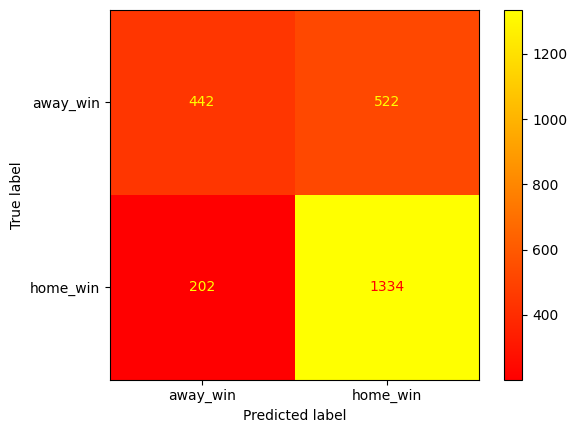

In [6]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['sag', 'saga'],
}

classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)
class_weights = dict(zip(classes, class_weights_array))
logreg = LogisticRegression(
    # class_weight=class_weights, # это только хуже делает
    max_iter=2000,
    random_state=91
)

grid_search = GridSearchCV(logreg, param_grid, cv=8, scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search.fit(X_train_processed, y_train, sample_weight=weights_train)
best_clf = grid_search.best_estimator_
scores = cross_val_score(best_clf, preprocessor.transform(X), y, cv=8, scoring='accuracy')
print("Best Params:", grid_search.best_params_)

best_clf.fit(X_train_processed, y_train, sample_weight=weights_train)

# tests
y_pred = best_clf.predict(X_test_processed)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test, y_pred, target_names=['away_win','home_win']))
ConfusionMatrixDisplay(cm, display_labels=['away_win','home_win']).plot(cmap='autumn')

with open('../backend/goalsight/ml_models/model.pkl', 'wb') as f:
    pickle.dump(best_clf, f)

metrics = {
    'cv_accuracy': scores.mean(),
    'cv_std': scores.std(),
    **classification_report(y_test, y_pred, output_dict=True)
}

metrics_path = '../backend/goalsight/ml_models/metrics.json'
with open(metrics_path, 'w') as f:
    json.dump(metrics, f, indent=2)

with open('../backend/goalsight/ml_models/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

feature_list = [f for f in available_features if f != 'result_label']
with open('features.json', 'w') as f:
    json.dump(feature_list, f)

class_mapping = {"non_win": 0,"home_win": 1}
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)

### 14. Multi-Layer Perceptron (MLP) Training and Evaluation
Training and evaluating a neural network model for enhanced pattern recognition in match outcome prediction.

**Model architecture:**
- Hidden layer configurations tested
- Multiple activation functions
- Adaptive learning rate
- Early stopping to prevent overfitting

**Hyperparameters tuned:**
- Hidden layer sizes: (50,), (100,), (50,25), (100,50)
- Activation functions: ReLU, tanh
- Learning rate schedules: constant, adaptive
- Regularization strength (alpha)

**Advanced features:**
- Early stopping with validation monitoring
- Regularization for generalization
- Comprehensive grid search optimization

Fitting 8 folds for each of 64 candidates, totalling 512 fits
Лучшие параметры MLP: {'activation': 'tanh', 'alpha': 0.1, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
MLP CV accuracy: 0.7002 ± 0.0146
Confusion matrix for MLP:
[[ 451  513]
 [ 207 1329]]
Classification report for MLP:
              precision    recall  f1-score   support

    away_win       0.69      0.47      0.56       964
    home_win       0.72      0.87      0.79      1536

    accuracy                           0.71      2500
   macro avg       0.70      0.67      0.67      2500
weighted avg       0.71      0.71      0.70      2500



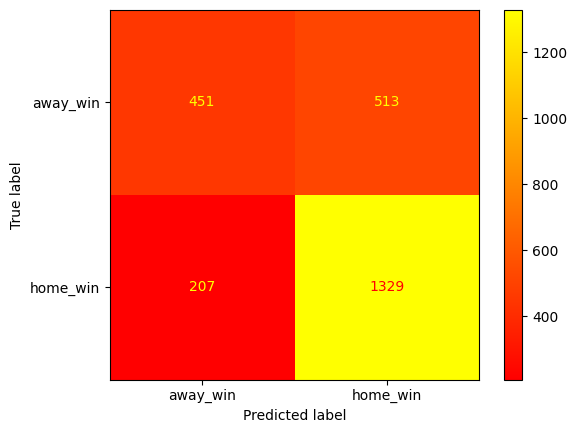

In [7]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'adaptive'],
    'alpha': [0.0001, 0.001, 0.01, 0.1]
}

mlp = MLPClassifier(
    hidden_layer_sizes=(200,),
    activation='relu',
    learning_rate='adaptive',
    alpha=0.001,
    max_iter=2000,
    random_state=91,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=10
)

grid_search_mlp = GridSearchCV(
    mlp,
    param_grid,
    cv=8,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
grid_search_mlp.fit(X_train_processed, y_train)
best_mlp = grid_search_mlp.best_estimator_
print("Лучшие параметры MLP:", grid_search_mlp.best_params_)
mlp_scores = cross_val_score(
    best_mlp,
    preprocessor.transform(X),
    y,
    cv=8,
    scoring='accuracy'
)
print(f"MLP CV accuracy: {mlp_scores.mean():.4f} ± {mlp_scores.std():.4f}")
best_mlp.fit(X_train_processed, y_train)
y_pred_mlp = best_mlp.predict(X_test_processed)
print("Confusion matrix for MLP:")
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
print(cm_mlp)
print("Classification report for MLP:")
print(classification_report(y_test, y_pred_mlp, target_names=['away_win','home_win']))
ConfusionMatrixDisplay(cm_mlp, display_labels=['away_win','home_win']).plot(cmap='autumn')

### 15. Ensemble Models Setup

Defining a diverse set of base learners to combine into ensemble predictors.
Includes:
- **Logistic Regression** and **MLPClassifier** (previously optimized)
- **Support Vector Machine** for margin-based classification
- **Random Forest** for bagged decision trees
- **XGBoost** for gradient-boosted trees
- **Gaussian Naive Bayes** for probabilistic modeling

Each model brings complementary strengths to the ensemble.

In [11]:
def get_base_models():
    models = []
    models.append(('lr', LogisticRegression(C=1, solver='sag', max_iter=2000, random_state=91)))
    models.append(('mlp', MLPClassifier(
        hidden_layer_sizes=(50,),
        activation='tanh',
        learning_rate='constant',
        alpha=0.0001,
        max_iter=2000,
        random_state=91,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=10
    )))
    models.append(('svm', SVC(probability=True, random_state=91)))
    models.append(('rf', RandomForestClassifier(n_estimators=100, random_state=91)))
    models.append(('xgb', xgb.XGBClassifier(random_state=91, eval_metric='logloss')))
    models.append(('nb', GaussianNB()))
    return models

base_models = get_base_models()
print(f"base models for ensemble: {[name for name, _ in base_models]}")

Базовые модели для ансамбля: ['lr', 'mlp', 'svm', 'rf', 'xgb', 'nb']


### 16. Voting Classifier (Hard and Soft Voting)

Applying **VotingClassifier** to aggregate base model predictions:
- **Hard Voting**: majority voting of discrete class labels
- **Soft Voting**: averaging predicted class probabilities

Hard voting often yields stable results, while soft voting can leverage probability calibration.

In [12]:
print("=== VOTING CLASSIFIER (HARD) ===")
voting_hard = VotingClassifier(
    estimators=base_models,
    voting='hard'
)

voting_hard.fit(X_train_processed, y_train)
y_pred_voting_hard = voting_hard.predict(X_test_processed)

print("Hard Voting Results:")
print(confusion_matrix(y_test, y_pred_voting_hard))
print(classification_report(y_test, y_pred_voting_hard, target_names=['away_win','home_win']))
voting_hard_accuracy = accuracy_score(y_test, y_pred_voting_hard)
print(f"Hard Voting Accuracy: {voting_hard_accuracy:.4f}")

print("\n=== VOTING CLASSIFIER (SOFT) ===")
voting_soft = VotingClassifier(
    estimators=base_models,
    voting='soft'
)

voting_soft.fit(X_train_processed, y_train)
y_pred_voting_soft = voting_soft.predict(X_test_processed)

print("Soft Voting Results:")
print(confusion_matrix(y_test, y_pred_voting_soft))
print(classification_report(y_test, y_pred_voting_soft, target_names=['away_win','home_win']))
voting_soft_accuracy = accuracy_score(y_test, y_pred_voting_soft)
print(f"Soft Voting Accuracy: {voting_soft_accuracy:.4f}")

=== VOTING CLASSIFIER (HARD) ===
Hard Voting Results:
[[ 535  410]
 [ 238 1086]]
              precision    recall  f1-score   support

    away_win       0.69      0.57      0.62       945
    home_win       0.73      0.82      0.77      1324

    accuracy                           0.71      2269
   macro avg       0.71      0.69      0.70      2269
weighted avg       0.71      0.71      0.71      2269

Hard Voting Accuracy: 0.7144

=== VOTING CLASSIFIER (SOFT) ===
Soft Voting Results:
[[ 511  434]
 [ 218 1106]]
              precision    recall  f1-score   support

    away_win       0.70      0.54      0.61       945
    home_win       0.72      0.84      0.77      1324

    accuracy                           0.71      2269
   macro avg       0.71      0.69      0.69      2269
weighted avg       0.71      0.71      0.70      2269

Soft Voting Accuracy: 0.7126


### 17. Stacking Classifier

Building a **StackingClassifier** that:
1. Trains base learners with cross-validated predictions
2. Uses a **Logistic Regression** meta-model on their probability outputs
3. Optionally experiments with alternative meta-models (Random Forest, XGBoost)

Stacking can capture higher-order relationships among base predictions.

In [21]:
print("\n=== STACKING CLASSIFIER ===")

stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(random_state=91),
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

stacking_clf.fit(X_train_processed, y_train)
y_pred_stacking = stacking_clf.predict(X_test_processed)

print("Stacking Results:")
print(confusion_matrix(y_test, y_pred_stacking))
print(classification_report(y_test, y_pred_stacking, target_names=['away_win','home_win']))
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Accuracy: {stacking_accuracy:.4f}")

print("\n=== STACKING WITH DIFFERENT META-MODELS ===")

meta_models = [
    ('lr_meta', LogisticRegression(random_state=91)),
    ('rf_meta', RandomForestClassifier(n_estimators=50, random_state=91)),
    ('xgb_meta', xgb.XGBClassifier(random_state=91, eval_metric='logloss'))
]

stacking_results = {}
for meta_name, meta_model in meta_models:
    stack_clf = StackingClassifier(
        estimators=base_models,
        final_estimator=meta_model,
        cv=3,
        n_jobs=-1
    )

    stack_clf.fit(X_train_processed, y_train)
    y_pred = stack_clf.predict(X_test_processed)
    acc = accuracy_score(y_test, y_pred)
    stacking_results[meta_name] = acc
    print(f"Stacking with {meta_name}: {acc:.4f}")


=== STACKING CLASSIFIER ===
Stacking Results:
[[ 541  404]
 [ 238 1086]]
              precision    recall  f1-score   support

    away_win       0.69      0.57      0.63       945
    home_win       0.73      0.82      0.77      1324

    accuracy                           0.72      2269
   macro avg       0.71      0.70      0.70      2269
weighted avg       0.71      0.72      0.71      2269

Stacking Accuracy: 0.7171

=== STACKING WITH DIFFERENT META-MODELS ===
Stacking with lr_meta: 0.7166
Stacking with rf_meta: 0.6884
Stacking with xgb_meta: 0.6968


### 18. Blending Ensemble

Implementing manual blending:
1. **Split** the training set into training and hold-out folds
2. **Train** each base model on the training fold
3. **Predict** probabilities on the hold-out and test sets
4. **Fit** a meta-learner (Logistic Regression) on hold-out predictions
5. **Combine** test-set probabilities via the trained blender

Blending is a simpler, faster variant of stacking with a single hold-out split.

In [27]:
print("\n=== BLENDING ENSEMBLE ===")

def create_blending_ensemble(models, X_train, X_val, y_train, y_val, X_test):
    """
    Create blending ensemble
    """
    blend_train = np.zeros((X_val.shape[0], len(models)))
    blend_test = np.zeros((X_test.shape[0], len(models)))

    for i, (name, model) in enumerate(models):
        print(f"Training {name} for blending...")
        model.fit(X_train, y_train)

        y_val_pred = model.predict_proba(X_val)[:, 1]  # Вероятность класса 1
        blend_train[:, i] = y_val_pred

        y_test_pred = model.predict_proba(X_test)[:, 1]
        blend_test[:, i] = y_test_pred

    blender = LogisticRegression(random_state=91)
    blender.fit(blend_train, y_val)

    final_predictions = blender.predict(blend_test)
    return final_predictions, blender

X_blend_train, X_blend_val, y_blend_train, y_blend_val = train_test_split(
    X_train_processed, y_train, test_size=0.2, stratify=y_train, random_state=91
)

y_pred_blending, blender_model = create_blending_ensemble(
    base_models,
    X_blend_train, X_blend_val, y_blend_train, y_blend_val, X_test_processed
)

print("Blending Results:")
print(confusion_matrix(y_test, y_pred_blending))
print(classification_report(y_test, y_pred_blending, target_names=['away_win','home_win']))
blending_accuracy = accuracy_score(y_test, y_pred_blending)
print(f"Blending Accuracy: {blending_accuracy:.4f}")


=== BLENDING ENSEMBLE ===
Training lr for blending...
Training mlp for blending...
Training svm for blending...
Training rf for blending...
Training xgb for blending...
Training nb for blending...
Blending Results:
[[ 554  391]
 [ 248 1076]]
              precision    recall  f1-score   support

    away_win       0.69      0.59      0.63       945
    home_win       0.73      0.81      0.77      1324

    accuracy                           0.72      2269
   macro avg       0.71      0.70      0.70      2269
weighted avg       0.72      0.72      0.71      2269

Blending Accuracy: 0.7184


### 19. Weighted Averaging Ensemble

Combining base model probability predictions with custom weights:
- **Equal** weights for uniform influence
- **lr_heavy** emphasizing logistic regression
- **balanced** proportional to cross-validated performance

Weighted averaging is intuitive and often competitive with minimal tuning.

In [29]:
print("\n=== WEIGHTED AVERAGING ===")

def weighted_ensemble_predictions(models, X_train, X_test, y_train, weights=None):
    """
    Create weighted ensemble
    """
    if weights is None:
        weights = [1.0] * len(models)

    weights = np.array(weights)
    weights = weights / weights.sum()

    predictions = np.zeros(X_test.shape[0])

    for i, (name, model) in enumerate(models):
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        predictions += weights[i] * y_pred_proba

    final_predictions = (predictions > 0.5).astype(int)
    return final_predictions

weight_schemes = {
    'equal': [1, 1, 1, 1],
    'lr_heavy': [3, 1, 1, 1],
    'balanced': [2, 2, 1, 1],
}

weighted_results = {}
for scheme_name, weights in weight_schemes.items():
    y_pred_weighted = weighted_ensemble_predictions(
        base_models[:4], X_train_processed, X_test_processed, y_train, weights
    )

    acc = accuracy_score(y_test, y_pred_weighted)
    weighted_results[scheme_name] = acc
    print(f"Weighted Averaging ({scheme_name}): {acc:.4f}")


=== WEIGHTED AVERAGING ===
Weighted Averaging (equal): 0.7126
Weighted Averaging (lr_heavy): 0.7175
Weighted Averaging (balanced): 0.7184


### 20. Performance Comparison

Aggregating accuracy scores for:
- **Individual models** (Logistic Regression, MLP)
- **Ensembles** (Hard/Soft Voting, Stacking, Blending, Weighted Averaging)

Identifying the best-performing approach and measuring improvement over the best single model.

In [30]:
print("\n=== COMPARISON OF ALL APPROACHES ===")

y_pred = best_clf.predict(X_test_processed)

individual_scores = {
    'Logistic Regression': accuracy_score(y_test, y_pred),
    'MLP': accuracy_score(y_test, y_pred_mlp)
}

ensemble_scores = {
    'Hard Voting': voting_hard_accuracy,
    'Soft Voting': voting_soft_accuracy,
    'Stacking': stacking_accuracy,
    'Blending': blending_accuracy,
}

ensemble_scores.update({f'Weighted ({k})': v for k, v in weighted_results.items()})

print("Individual Models:")
for name, score in individual_scores.items():
    print(f"  {name}: {score:.4f}")

print("\nEnsemble Models:")
for name, score in ensemble_scores.items():
    print(f"  {name}: {score:.4f}")

all_scores = {**individual_scores, **ensemble_scores}
best_model = max(all_scores, key=all_scores.get)
print(f"\nBest performing model: {best_model} with accuracy: {all_scores[best_model]:.4f}")

best_individual = max(individual_scores.values())
best_ensemble = max(ensemble_scores.values())
improvement = best_ensemble - best_individual
print(f"Improvement over best individual model: {improvement:.4f} ({improvement*100:.2f}%)")


=== COMPARISON OF ALL APPROACHES ===
Individual Models:
  Logistic Regression: 0.7215
  MLP: 0.7087

Ensemble Models:
  Hard Voting: 0.7144
  Soft Voting: 0.7126
  Stacking: 0.7171
  Blending: 0.7184
  Weighted (equal): 0.7126
  Weighted (lr_heavy): 0.7175
  Weighted (balanced): 0.7184

Best performing model: Logistic Regression with accuracy: 0.7215
Improvement over best individual model: -0.0031 (-0.31%)


### 21. Results Visualization

Creating a bar chart to compare accuracies:
- **Individual models** in blue  
- **Ensemble methods** in red  

Annotations show exact accuracy values. Visual comparison highlights which ensemble (or individual) model performs best.


=== VISUALIZATION ===


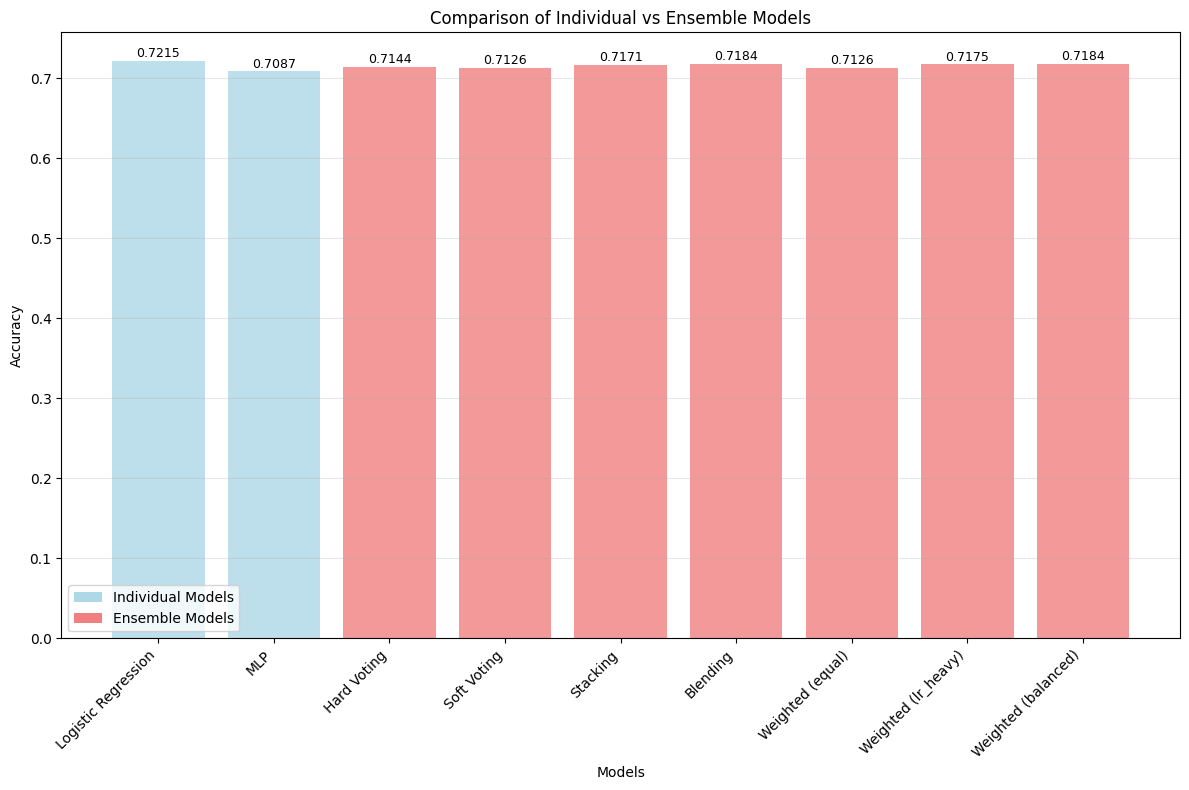

In [31]:
print("\n=== VISUALIZATION ===")

plt.figure(figsize=(12, 8))
models = list(all_scores.keys())
scores = list(all_scores.values())
colors = []
for model in models:
    if any(x in model.lower() for x in ['voting', 'stacking', 'blending', 'weighted']):
        colors.append('lightcoral')
    else:
        colors.append('lightblue')

bars = plt.bar(range(len(models)), scores, color=colors, alpha=0.8)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Individual vs Ensemble Models')
plt.xticks(range(len(models)), models, rotation=45, ha='right')

for i, (bar, score) in enumerate(zip(bars, scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{score:.4f}', ha='center', va='bottom', fontsize=9)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', label='Individual Models'),
                   Patch(facecolor='lightcoral', label='Ensemble Models')]
plt.legend(handles=legend_elements)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()